June 2nd, 2025 


# ECDI-like Linear Theory 
#### [V. Roytershteyn and G. L. Delzanno. *Nonlinear coupling of whistler waves to oblique electrostatic turbulence enabled by cold plasma*. Physics of Plasmas, 28(4):042903, 04 2021](https://pubs.aip.org/aip/pop/article-abstract/28/4/042903/263604/Nonlinear-coupling-of-whistler-waves-to-oblique?redirectedFrom=fulltext)


Author: Opal Issan (oissan@ucsd.edu)

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
from scipy.sparse import diags

In [4]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [5]:
# important basic functions 

def Z(z):
    # plasma dispersion function Z(xi)
    return 1j * np.sqrt(np.pi) * wofz(z)
    
def Z_prime(z):
    # derivative of the plasma dispersion function Z'(xi)
    return -2*(1+z*Z(z))

def I(Lambda_e, m):
    # modified Bessel function of the first kind I_{m}(\lambda) x exp(-lambda)
    return scipy.special.ive(m, Lambda_e)

def J(Lambda_e, m):
    # Bessel function of the first kind J_{m}(\lambda)
    return scipy.special.jv(m, Lambda_e)

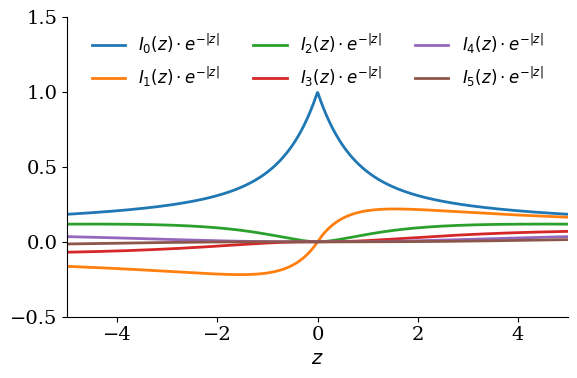

In [6]:
# Visualize the modified Bessel functions 
fig, ax = plt.subplots(figsize=(6, 4))
x = np.linspace(-5., 5., 1000)
for i in np.arange(0, 6):
    ax.plot(x, I(m=i, Lambda_e=x), label=fr'$I_{i!r}(z)\cdot e^{{-|z|}}$', linewidth=2)
ax.set_xlabel(r"$z$")
ax.set_ylim(-0.5, 1.5)
ax.set_xlim(np.min(x), np.max(x))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend = ax.legend(loc='upper center', ncols=3, fancybox=False, shadow=False, fontsize=12)
legend.get_frame().set_alpha(0)
plt.tight_layout()

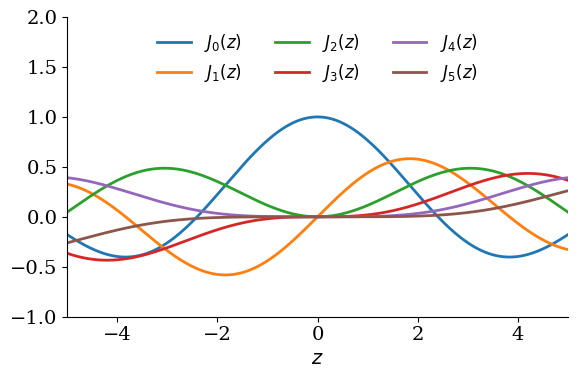

In [7]:
# Visualize the Bessel function 
fig, ax = plt.subplots(figsize=(6, 4))
x = np.linspace(-5., 5., 1000)
for i in np.arange(0, 6):
    ax.plot(x, J(m=i, Lambda_e=x), label=fr'$J_{i!r}(z)$', linewidth=2)
ax.set_xlabel(r"$z$")
ax.set_ylim(-1, 2)
ax.set_xlim(np.min(x), np.max(x))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend = ax.legend(loc='upper center', ncols=3, fancybox=False, shadow=False, fontsize=12)
legend.get_frame().set_alpha(0)
plt.tight_layout()

## Electrostatic perpendicular dispersion relation 
The dispersion relation is 
\begin{align*}
    k_{\perp}^2 + \epsilon_{c}(\omega, k_{\perp}) &= \epsilon_{i}(\omega, k_{\perp})\\
    \epsilon_{c}(\omega, k_{\perp}) &=- \frac{n_{c}}{n_{e}} \frac{4\omega_{pe}^2}{\alpha_{\perp c}^2} \sum_{n=1}^{\infty} \overbrace{\exp(-\lambda) I_{n}(\lambda)}^{\texttt{ive(n, } \lambda)} \frac{ n^2\Omega_{ce}^2}{\omega^2 - n^2 \Omega_{ce}^2}\\
    \epsilon_{i}(\omega, k_{\perp})&=\frac{\omega_{pi}^2}{\alpha_{i}^2} [\underbrace{J_{m*}(a)}_{\texttt{jv(m*, a)}}]^2 Z{'}\left(\frac{\omega + m_{*} \omega_{0}}{k \alpha_{i}}\right)\\
    a &\coloneqq \frac{k_{\perp} |V_{Dc}|}{ \omega_{0}}\\
    \lambda &\coloneqq \frac{1}{2} \frac{k_{\perp}^2 \alpha_{\perp c}^2}{\Omega_{ce}^2} 
\end{align*} 

In [8]:
# normalization 
# time is normalized to the electron cyclotron frequency 1/Omega_ce
# space is normalized to electron inertial length d_e
n_c = 4/5 # n^e_0
omega_0 = 0.45 # Omega_ce

omega_pe = 4 # Omgea_{ce}
alpha_perp_c = 0.0079 # d_e x Omega_ce
alpha_i =  alpha_perp_c / np.sqrt(1836) # d_e x Omega_ce

v_0 = 0.65 * alpha_perp_c # d_e x Omega_ce
omega_pi = omega_pe / np.sqrt(1836) # Omega_ce

In [32]:
def sum_bessel(lambda_, omega, n_max=10):
    res =0 
    for n in range(1, n_max):
        res += I(m=n, Lambda_e=lambda_) * (n**2) / (omega**2 - n**2)
    return res

def ion_response(omega_pi, alpha_i, m_star, omega, omega_0, k_perp, v_0):
    a = k_perp * np.abs(v_0) / omega_0
    return (omega_pi**2)/(alpha_i**2) * (J(m=m_star, Lambda_e=a)**2) * Z_prime((omega + m_star*omega_0)/(k_perp*alpha_i))

def cold_electron_response(k_perp, omega, n_max, omega_pe, alpha_perp_c, n_c):
    lambda_ =  (k_perp*alpha_perp_c/np.sqrt(2))**2
    return -n_c * 4 * (omega_pe**2) /(alpha_perp_c**2) * sum_bessel(lambda_=lambda_, omega=omega, n_max=n_max)
    
def disp_k(k_perp, 
           omega_pe=omega_pe, 
           omega_pi=omega_pi, 
           v_0=v_0, 
           alpha_i=alpha_i, 
           alpha_perp_c=alpha_perp_c,
           n_c=n_c, 
           m_star=-3, 
           n_max=50):
    return lambda omega : k_perp**2\
                         + cold_electron_response(k_perp=k_perp, omega=omega, n_max=n_max, omega_pe=omega_pe, alpha_perp_c=alpha_perp_c, n_c=n_c) \
                         - ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=m_star, v_0=v_0, omega=omega, omega_0=omega_0, k_perp=k_perp)

In [33]:
k_perp = 150 
sol = scipy.optimize.newton(disp_k(k_perp=k_perp), omega_0*3 + 0.005j, maxiter=10000)
print("omega_k + i gamma = ", sol)
print("dispersion residual = ", abs(disp_k(k_perp=k_perp)(sol)))

omega_k + i gamma =  (1.5936966660279224-2.9136939432879733e-18j)
dispersion residual =  1.6529320022472008e-12


In [34]:
k_perp_ = np.linspace(200, 250, 60)
sol_ = np.zeros(len(k_perp_), dtype="complex128")

In [35]:
for ii in range(len(k_perp_)):
    try:
        sol_[ii] = scipy.optimize.newton(disp_k(k_perp=k_perp_[ii]), omega_0*3 + 0.0005j, maxiter=10000)
        print("dispersion residual = ", abs(disp_k(k_perp=k_perp_[ii])(sol_[ii])))
    except:
        print("An exception occurred")

dispersion residual =  1.3476397933048007e-08
dispersion residual =  3.363031051128073e-10
dispersion residual =  1.3847162132092314e-10
dispersion residual =  1.3484084260458466e-09
dispersion residual =  1.3698543359513076e-10
dispersion residual =  1.9261632642470926e-08
dispersion residual =  1.2345246398859195e-06
dispersion residual =  1.2966728192955175e-09
dispersion residual =  1.9253811656961977e-10
dispersion residual =  5.2737337873829234e-08
dispersion residual =  5.885997879007515e-10
dispersion residual =  7.848894686694187e-08
dispersion residual =  3.1480605907249173e-10
dispersion residual =  2.194875412804547e-06
dispersion residual =  3.9892436757632727e-08
dispersion residual =  4.688090109579161e-10
dispersion residual =  3.9712750545556554e-10
dispersion residual =  2.8637808230505005e-07
dispersion residual =  8.882903034207209e-09
dispersion residual =  2.2254946946066864e-10
dispersion residual =  2.3745302540516214e-10
dispersion residual =  2.271874712389346

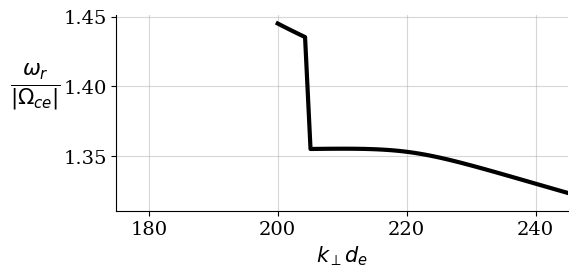

In [36]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_perp_, sol_.real, linewidth=3, color="black")
ax.set_ylabel(r'$\frac{\omega_r}{|\Omega_{ce}|}$', fontsize=22, labelpad=20, rotation=0)
ax.set_xlabel('$k_{\perp}d_{e}$', fontsize=15)
ax.set_xticks([180, 200, 220, 240])
ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("../../figs/vadim_2021/vadim_fig5_a.png", dpi=300, bbox_inches='tight')

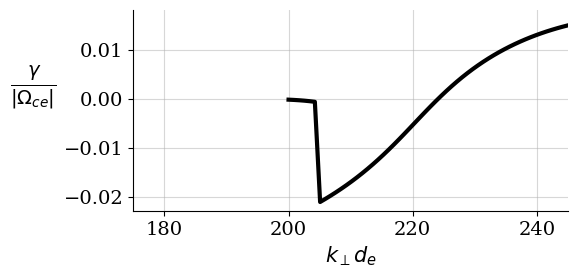

In [37]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_perp_, sol_.imag, linewidth=3, color="black")
ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{ce}|}$', labelpad=22, rotation=0, fontsize=20)
ax.set_xlabel('$k_{\perp}d_{e}$', fontsize=15)
ax.set_xticks([180, 200, 220, 240])
#ax.set_ylim(-0.0001, 0.0075)
ax.set_xlim(175, 245)
#ax.set_yticks([0, 0.0025, 0.005, 0.0075])
#ax.set_yticklabels([0, 0.0025, 0.005, 0.0075])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("../../figs/vadim_2021/vadim_fig5_b.png", dpi=300, bbox_inches='tight')

# understanding the instability 

In [38]:
ion_feedback = ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-3, v_0=v_0, omega=sol_, omega_0=omega_0, k_perp=k_perp_)

electron_feedback = k_perp_**2 +cold_electron_response(k_perp=k_perp_, 
                                                       omega=sol_, n_max=7, 
                                                       omega_pe=omega_pe, alpha_perp_c=alpha_perp_c, n_c=n_c)

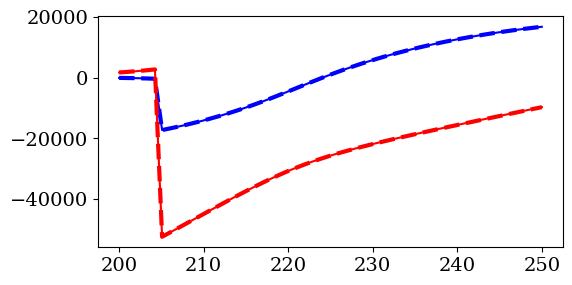

In [39]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(k_perp_, electron_feedback.imag, color="blue", ls="--", linewidth=3)
ax.plot(k_perp_, ion_feedback.imag, color="blue")
ax.plot(k_perp_, electron_feedback.real, color="red", ls="--", linewidth=3)
ax.plot(k_perp_, ion_feedback.real, color="red")

#ax.set_yscale("log")

#

In [40]:
k_perp = 250

In [41]:
omega_ = np.linspace(0.1, 5, 500)
electron_feedback = k_perp**2 +cold_electron_response(k_perp=k_perp, omega=omega_, n_max=50, 
                                                           omega_pe=omega_pe, alpha_perp_c=alpha_perp_c, n_c=n_c)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_6692/2157211366.py:4: RuntimeWarning: divide by zero encountered in divide
  res += I(m=n, Lambda_e=lambda_) * (n**2) / (omega**2 - n**2)


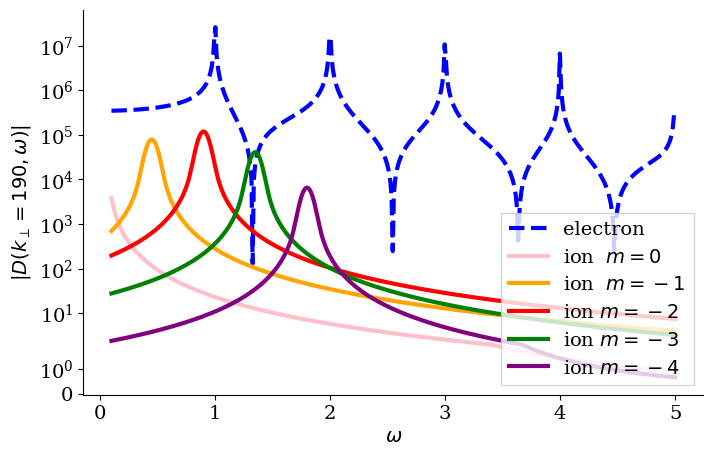

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(omega_, np.abs(electron_feedback), color="blue", ls="--", linewidth=3, label="electron")

ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=0, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="pink",  linewidth=3, label="ion  $m=0$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-1, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="orange",  linewidth=3, label="ion  $m=-1$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-2, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="red",  linewidth=3, label="ion $m=-2$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-3, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="green",  linewidth=3, label="ion $m=-3$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-4, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="purple",  linewidth=3, label="ion $m=-4$")

legend = ax.legend(ncols=1, fancybox=False, shadow=False,  loc="lower right")
#legend.get_frame().set_alpha(0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("$\omega$")
ax.set_ylabel("$|D(k_{\perp} =190, \omega)|$")
ax.set_yscale("symlog")
plt.savefig("../../figs/vadim_2021/side_bands_ecdi.png", dpi=300)